In [4]:
import csv
import numpy as np
from scipy import special
from scipy.special import softmax
import matplotlib.pyplot as plt

data = {}
returning_prod = {}
teams = []
num_teams = 130

# Add Returning Production (as a Percentage) from the last season for each team
with open ('ret.csv', newline='') as file:
        lines = csv.reader(file)
        c = 0

        for l in lines:
            try:
                returning_prod[l[1]] = float(l[11])

            except Exception:
                continue

# Build the Adjacency Matrix:
            # Node : CFB Team (FBS)
            # Edge : Victory / Defeat over other team
def build_graph(week, year):
    year = str(year)

    with open (year+'.csv', newline='') as file:
        lines = csv.reader(file)
        c = 0

        for l in lines:

            try:
                if l[15] != "":
                    if l[14] != "fbs" or l[26] != 'fbs':
                        continue
                    else:
                        k1 = l[12]
                        k2 = l[24]

                if k1 not in teams:
                    teams.append(k1)
                if k2 not in teams:
                    teams.append(k2)

            except Exception:
                continue

    num_teams = len(teams)
    g = np.zeros((num_teams,num_teams))


    with open (year+'.csv', newline='') as file:
        lines = csv.reader(file)
        for l in lines:
            
                try:

                    if float(l[2]) <= week:
                        if l[14] != "":
                            if l[14] != "fbs" or l[26] != 'fbs':
                                continue
                            else:
                                k1 = teams.index(l[12])
                                k2 = teams.index(l[24])

                                d1 = float(l[15])
                                d2 = float(l[27])

                                dif = d1-d2

                                if dif > 0: 
                                    dif = np.log(dif)
                                    g[k1][k2] = dif
                                    g[k2][k1] = -dif

                                elif dif < 0:
                                    dif = np.log(-dif)
                                    g[k1][k2] = -dif
                                    g[k2][k1] = dif

                except Exception:
                    continue

    return g, num_teams
        
# Page Rank Centrality
def pr(A, alpha=0.85, num_teams=130, num_terms=10):
    e = np.ones(num_teams) # 1 vector
    D = np.identity(num_teams)
    adj = np.identity(num_teams)
    x = np.zeros(num_teams)
    v = [1/num_teams if sum(A[i]) >=0 else -1/num_teams for i in range(num_teams)]
    v = np.array(v)
    E = np.array([[v[i] for i in range(num_teams)] for j in range(num_teams)])

    for k in range(num_terms):
        adj = adj @ A

        for j in range(num_teams):
            d = sum(np.abs(adj[j]))
            if d == 0: D[j][j] = 0
            else: D[j][j] = 1/d

        P = alpha**k * adj@D + 1000*E
        x += P @ e #+ (1-alpha)**k * v

    return x

# Get the Largest Elements (Rank the Teams)
def largest_elements(lst,k=25):
        return np.flip(np.argsort(lst)[-1*k:])

# Predict the games next week using rankings
def predict_games(week, num_teams, year, x, filter_teams=False):

    year=str(year)

    with open (year+'.csv', newline='') as file:
        lines = csv.reader(file)
        result_matrix = np.zeros((num_teams,num_teams))
        num_games = 0

        for l in lines:
            try:
                if float(l[2]) == week:
                    if l[14] != "":
                        if l[14] != "fbs" or l[26] != 'fbs':
                            continue
                        else:
                            k1 = teams.index(l[12])
                            k2 = teams.index(l[24])

                            d1 = float(l[15])
                            d2 = float(l[27])

                            dif = d1-d2
                            num_games += 1

                            # won and predicted a win
                            if dif > 0:

                                
                                if x[k1] > x[k2]: result_matrix[k1][k2] = 1
                                else: result_matrix[k1][k2] = 0

                            # lost and predicted a loss
                            else: 
                                if x[k1] < x[k2]: result_matrix[k2][k1] = 1
                                else: result_matrix[k2][k1] = 0

            except Exception:
                continue

        return np.sum(result_matrix), num_games

# Prediction Loop: Loop over all games for the given years starting at start_week
def prediction_loop(years, num_terms,start_week=3):
    games, tot = 0, 0
    for year in years:
        for w in range(start_week,15):
            g,num_teams = build_graph(w,year)
            r = pr(g,.45,num_teams, num_terms)
            a, num_games = predict_games(w+1, num_teams, year, r)
            # print("Week: " + str(w+1) + ": " + str(a/num_games))
            tot += a
            games += num_games 

    print("Total Percentage: ", tot/games)
    return tot/games

# Rank Teams this year
def rankings(year):
    g,num_teams = build_graph(15,year)
    r = pr(g, 0.85, num_teams)
    k = 60
    indices = largest_elements(r, k)

    for i in range(k):
        print(str(i+1) + ": ", teams[indices[i]])

# predict the games next week using rankings
def predict_games_top(week, num_teams, year, x, indices):

    year=str(year)

    with open (year+'.csv', newline='') as file:
        lines = csv.reader(file)
        result_matrix = np.zeros((num_teams,num_teams))
        num_games = 0

        for l in lines:
            try:
                if float(l[2]) == week:
                    if l[14] != "":
                        if l[14] != "fbs" or l[26] != 'fbs':
                            continue
                        else:
                            k1 = teams.index(l[12])
                            k2 = teams.index(l[24])

                            if k1 in indices or k2 in indices:
                                d1 = float(l[15])
                                d2 = float(l[27])

                                dif = d1-d2
                                num_games += 1

                                # won and predicted a win
                                if dif > 0:
                                    
                                    if x[k1] > x[k2]: result_matrix[k1][k2] = 1
                                    else: result_matrix[k1][k2] = 0

                                # lost and predicted a loss
                                else: 
                                    if x[k1] < x[k2]: result_matrix[k2][k1] = 1
                                    else: result_matrix[k2][k1] = 0

            except Exception:
                continue

        return np.sum(result_matrix), num_games

# Predict Games for Teams in the Top 25
def prediction_loop_top25(years,num_terms,start_week=3,k=25,end_week=15):
    games, tot = 0, 0
    for year in years:
        for w in range(start_week,end_week):
            g,num_teams = build_graph(w,year)
            r = pr(g,.45,num_teams,num_terms)
            top_25 = largest_elements(r, k)
            a, num_games = predict_games_top(w+1, num_teams, year, r, top_25)
            tot += a
            # print(a/num_games)
            games += num_games 

    print("Total Percentage: ", tot/games)
    return tot/games

Total Percentage:  0.6408345752608048
Total Percentage:  0.7934782608695652
Total Percentage:  0.7110091743119266
Total Percentage:  0.6506410256410257
Total Percentage:  0.7790697674418605
Total Percentage:  0.7073170731707317
Total Percentage:  0.6533101045296167
Total Percentage:  0.8
Total Percentage:  0.7120418848167539
Total Percentage:  0.6634241245136187
Total Percentage:  0.8028169014084507
Total Percentage:  0.711764705882353
Total Percentage:  0.6586433260393874
Total Percentage:  0.7777777777777778
Total Percentage:  0.6933333333333334
Total Percentage:  0.655
Total Percentage:  0.7592592592592593
Total Percentage:  0.676923076923077
Total Percentage:  0.673352435530086
Total Percentage:  0.7659574468085106
Total Percentage:  0.6902654867256637
Total Percentage:  0.6868686868686869
Total Percentage:  0.7906976744186046
Total Percentage:  0.7142857142857143
Total Percentage:  0.676
Total Percentage:  0.75
Total Percentage:  0.7176470588235294
Total Percentage:  0.66842105263

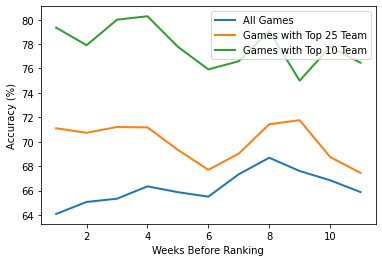

1:  Georgia
2:  Michigan
3:  Ohio State
4:  TCU
5:  USC
6:  Alabama
7:  Tennessee
8:  Penn State
9:  Texas
10:  Tulane
11:  Clemson
12:  Coastal Carolina
13:  Illinois
14:  Troy
15:  Notre Dame
16:  South Alabama
17:  UCF
18:  Boise State
19:  LSU
20:  Florida State
21:  Washington
22:  Louisville
23:  Kansas State
24:  North Carolina
25:  UT San Antonio
26:  James Madison
27:  Ohio
28:  Utah
29:  Liberty
30:  Duke
31:  UCLA
32:  Marshall
33:  Cincinnati
34:  Oregon State
35:  Air Force
36:  San José State
37:  Arkansas
38:  Houston
39:  Pittsburgh
40:  Ole Miss
41:  Purdue
42:  NC State
43:  Oregon
44:  Kentucky
45:  Oklahoma State
46:  Mississippi State
47:  UTEP
48:  Louisiana
49:  South Carolina
50:  Eastern Michigan
51:  North Texas
52:  Oklahoma
53:  Western Kentucky
54:  Wake Forest
55:  Fresno State
56:  Baylor
57:  Toledo
58:  Syracuse
59:  Memphis
60:  Appalachian State


In [6]:
x =[]
y = []
ys = [2022]
y1 = []
y2 = []
for start_week in range(1,12):
    x.append(start_week)
    y.append(prediction_loop(ys, 12, start_week))
    y2.append(prediction_loop_top25(ys, 12,start_week=start_week,k=10))
    y1.append(prediction_loop_top25(ys, 12,start_week=start_week))

plt.plot(x, [i*100 for i in y], label = "All Games", linewidth=2)
plt.plot(x, [i*100 for i in y1], label = "Games with Top 25 Team", linewidth=2)
plt.plot(x, [i*100 for i in y2], label = "Games with Top 10 Team", linewidth=2)
plt.xlabel("Weeks Before Ranking")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

rankings(2022)

Total Percentage:  0.6612903225806451
Total Percentage:  0.7647058823529411
Total Percentage:  0.7364016736401674
Total Percentage:  0.6781789638932496
Total Percentage:  0.7857142857142857
Total Percentage:  0.7477876106194691
Total Percentage:  0.676923076923077
Total Percentage:  0.7865168539325843
Total Percentage:  0.7464114832535885
Total Percentage:  0.6755218216318786
Total Percentage:  0.7875
Total Percentage:  0.7578947368421053
Total Percentage:  0.6845493562231759
Total Percentage:  0.7887323943661971
Total Percentage:  0.7647058823529411
Total Percentage:  0.6963855421686747
Total Percentage:  0.8032786885245902
Total Percentage:  0.7631578947368421
Total Percentage:  0.695054945054945
Total Percentage:  0.8035714285714286
Total Percentage:  0.781021897810219
Total Percentage:  0.7106109324758842
Total Percentage:  0.7755102040816326
Total Percentage:  0.788135593220339
Total Percentage:  0.7286821705426356
Total Percentage:  0.8095238095238095
Total Percentage:  0.8061224

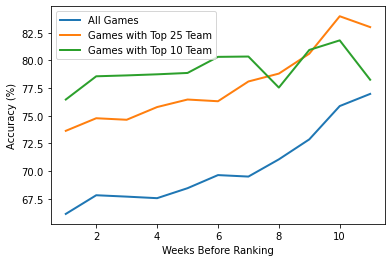

1:  Michigan
2:  Georgia
3:  Cincinnati
4:  Alabama
5:  Baylor
6:  Ohio State
7:  Pittsburgh
8:  Notre Dame
9:  UT San Antonio
10:  Louisiana
11:  NC State
12:  Oregon
13:  Appalachian State
14:  Utah
15:  Ole Miss
16:  Michigan State
17:  Oklahoma State
18:  Wake Forest
19:  Houston
20:  Boise State
21:  Army
22:  BYU
23:  Kentucky
24:  Wisconsin
25:  Minnesota
26:  Oklahoma
27:  Clemson
28:  Central Michigan
29:  Coastal Carolina
30:  Nevada
31:  Air Force
32:  Texas A&M
33:  San Diego State
34:  Western Kentucky
35:  Iowa
36:  Fresno State
37:  Penn State
38:  James Madison
39:  UCLA
40:  Utah State
41:  Toledo
42:  Mississippi State
43:  Oregon State
44:  Arkansas
45:  Wyoming
46:  UAB
47:  Iowa State
48:  Marshall
49:  Purdue
50:  Washington State
51:  Liberty
52:  SMU
53:  Miami (OH)
54:  Western Michigan
55:  Northern Illinois
56:  LSU
57:  UCF
58:  Memphis
59:  North Carolina
60:  Arizona State


In [7]:
x =[]
y = []
ys = [2021]
y1 = []
y2 = []
for start_week in range(1,12):
    x.append(start_week)
    y.append(prediction_loop(ys, 12, start_week))
    y2.append(prediction_loop_top25(ys, 12,start_week=start_week,k=10))
    y1.append(prediction_loop_top25(ys, 12,start_week=start_week))

plt.plot(x, [i*100 for i in y], label = "All Games", linewidth=2)
plt.plot(x, [i*100 for i in y1], label = "Games with Top 25 Team", linewidth=2)
plt.plot(x, [i*100 for i in y2], label = "Games with Top 10 Team", linewidth=2)
plt.xlabel("Weeks Before Ranking")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

rankings(2021)

Total Percentage:  0.6734397677793904
Total Percentage:  0.75
Total Percentage:  0.7400881057268722
Total Percentage:  0.6936236391912908
Total Percentage:  0.7857142857142857
Total Percentage:  0.772093023255814
Total Percentage:  0.6991596638655462
Total Percentage:  0.8043478260869565
Total Percentage:  0.79
Total Percentage:  0.7051282051282052
Total Percentage:  0.8072289156626506
Total Percentage:  0.7989130434782609
Total Percentage:  0.705050505050505
Total Percentage:  0.8026315789473685
Total Percentage:  0.7988165680473372
Total Percentage:  0.70917225950783
Total Percentage:  0.8235294117647058
Total Percentage:  0.8116883116883117
Total Percentage:  0.7088607594936709
Total Percentage:  0.8032786885245902
Total Percentage:  0.8161764705882353
Total Percentage:  0.7095808383233533
Total Percentage:  0.8076923076923077
Total Percentage:  0.8157894736842105
Total Percentage:  0.7275985663082437
Total Percentage:  0.7954545454545454
Total Percentage:  0.8181818181818182
Total 

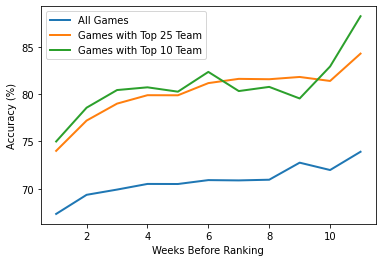

1:  Ohio State
2:  LSU
3:  Clemson
4:  Wisconsin
5:  Memphis
6:  Oregon
7:  Appalachian State
8:  Boise State
9:  Georgia
10:  Utah
11:  Oklahoma
12:  Alabama
13:  UCF
14:  Louisiana
15:  Penn State
16:  Baylor
17:  Notre Dame
18:  SMU
19:  Florida
20:  Air Force
21:  Auburn
22:  Navy
23:  Michigan
24:  San Diego State
25:  Minnesota
26:  Washington
27:  Iowa
28:  Cincinnati
29:  Florida Atlantic
30:  Virginia Tech
31:  Western Kentucky
32:  Iowa State
33:  Miami
34:  Arizona State
35:  Western Michigan
36:  James Madison
37:  Virginia
38:  USC
39:  Kansas State
40:  Oklahoma State
41:  Buffalo
42:  Kentucky
43:  Marshall
44:  Texas
45:  Louisiana Tech
46:  Ball State
47:  Wyoming
48:  Wake Forest
49:  Georgia State
50:  North Carolina
51:  BYU
52:  Boston College
53:  Hawai'i
54:  Syracuse
55:  Toledo
56:  Georgia Southern
57:  Pittsburgh
58:  Eastern Michigan
59:  Indiana
60:  Ohio


In [9]:
x =[]
y = []
ys = [2019]
y1 = []
y2 = []
for start_week in range(1,12):
    x.append(start_week)
    y.append(prediction_loop(ys, 12, start_week))
    y2.append(prediction_loop_top25(ys, 12,start_week=start_week,k=10))
    y1.append(prediction_loop_top25(ys, 12,start_week=start_week))

plt.plot(x, [i*100 for i in y], label = "All Games", linewidth=2)
plt.plot(x, [i*100 for i in y1], label = "Games with Top 25 Team", linewidth=2)
plt.plot(x, [i*100 for i in y2], label = "Games with Top 10 Team", linewidth=2)
plt.xlabel("Weeks Before Ranking")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

rankings(2019)